# Suitability Analysis: Best place within the Boston Region for a Tufts UEP student and BU Law student to live without a car 
UEP-239 Final Project\
By: Justina Cheng

[DESCRIPTION]

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim
from pyproj import CRS
from shapely.geometry import LineString, Point, Polygon, box

import rasterio
from rasterio.plot import show
from rasterio import features

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats

## Create and View Base Map of Boston Region Zip Code Tabulation Areas (ZCTAs)
To create a GeoDataFrame of the Boston Region ZCTAs, the following steps were used:
1. Massachusetts outline with detailed coastline was imported from MassGIS as a GeoDataFrame.
1. Massachusetts ZCTAs were imported from the Census Bureau as a GeoDataFrame.
1. The outline and ZCTAs GeoDataFrames were converted to the coordinate reference system (CRS) for the Massachusetts Mainland EPSG 6491.
1. Boundaries for the Boston Region Metropolitan Planning Organization (MPO) were imported from MassDOT as a GeoDataFrame, and the CRS was converted to EPSG 6491.
1. The Boston Region was extracted from the MPO.
1. Massachusetts ZCTAs within the Boston Region were extracted using the centroid of the ZCTAs.
1. Function `read_n_clip` was created to read in a shapefile, convert to the CRS of another GDF, and clip to the extent of the GDF.
1. Massachusetts Surface Water data from MassGIS was processed with `read_n_clip` with the extent of Boston ZCTAs. 

In [2]:
# Import outline of detailed Massachusetts coastline.
outline_25k = gpd.read_file("./data/outline25k/OUTLINE25K_POLY.shp")
outline_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AREA_ACRES  918 non-null    float64 
 1   OBJECTID    918 non-null    int64   
 2   SHAPE_AREA  918 non-null    float64 
 3   SHAPE_LEN   918 non-null    float64 
 4   geometry    918 non-null    geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 36.0 KB


epsg:26986


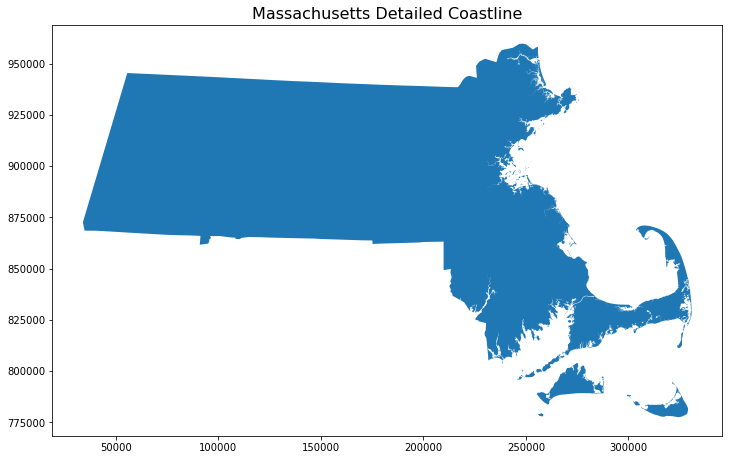

In [3]:
# View CRS and plot.
print(outline_25k.crs)
outline_25k.plot(figsize=(12,12))
plt.title('Massachusetts Detailed Coastline', fontsize=16)
plt.show()

In [4]:
# Import Zip Code Tabulation Areas within Massachusetts.
ma_zcta = gpd.read_file("./data/tl_2010_25_zcta500/tl_2010_25_zcta500.shp")
ma_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 47.1+ KB


epsg:4269


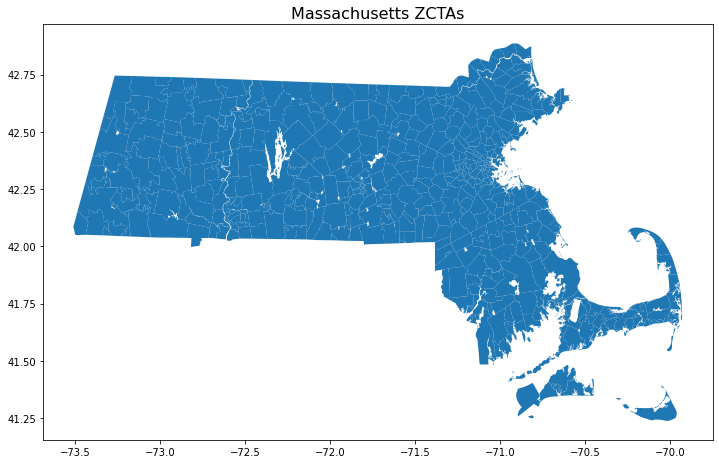

In [5]:
# View CRS and plot.
print(ma_zcta.crs)
ma_zcta.plot(figsize=(12,12))
plt.title('Massachusetts ZCTAs', fontsize=16)
plt.show()

In [6]:
# Convert CRS to Massachusetts Mainland EPSG 6491.
outline_25k = outline_25k.to_crs('epsg:6491')
ma_zcta = ma_zcta.to_crs('epsg:6491')
# Confirm CRSs match.
outline_25k.crs == ma_zcta.crs

True

In [7]:
# Clip ZCTA GDF to 25k MA outline.
ma_zcta_25k = gpd.clip(ma_zcta, outline_25k)
ma_zcta_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 50.9+ KB


In [8]:
# Import boundaries for Boston Region Metropolitan Planning Organization.
mpo = gpd.read_file("./data/MPO_Boundaries/MPO_Boundaries.shp")
mpo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    13 non-null     int64   
 1   MPO         13 non-null     object  
 2   created_us  0 non-null      object  
 3   created_da  13 non-null     object  
 4   last_edite  2 non-null      object  
 5   last_edi_1  13 non-null     object  
 6   GlobalID    13 non-null     object  
 7   ShapeSTAre  13 non-null     float64 
 8   ShapeSTLen  13 non-null     float64 
 9   geometry    13 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(6)
memory usage: 1.1+ KB


In [9]:
# View MPO dataset.
mpo

,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,2,Berkshire,None,1970-01-01,None,1970-01-01,{08FDA544-18B0-412A-B442-287E53E987F7},2.451015e+09,2.471530e+05,"POLYGON ((-8128884.676 5272654.345, -8128962.2..."
1,3,Cape Cod,None,1970-01-01,None,1970-01-01,{B6CD90CF-2F7D-43F2-B251-FA7F8E00EF01},1.067067e+09,1.288227e+06,"MULTIPOLYGON (((-7813968.781 5173329.197, -781..."
2,4,Central Massachusetts,None,1970-01-01,None,1970-01-01,{CC777E14-53C8-42AD-B421-71444DA0BB60},2.487546e+09,2.683265e+05,"POLYGON ((-7977225.352 5223837.273, -7973861.8..."
3,5,Franklin,None,1970-01-01,None,1970-01-01,{4804E708-6B89-4A85-9383-BD91F7589981},1.876456e+09,2.527017e+05,"POLYGON ((-8046511.241 5269691.856, -8045276.8..."
4,6,Montachusett,None,1970-01-01,None,1970-01-01,{F315DA63-C9CF-40EE-8AA7-5ABA2E1FD528},1.772355e+09,2.748684e+05,"POLYGON ((-7976246.504 5267152.001, -7976121.9..."
5,7,Martha's Vineyard,None,1970-01-01,None,1970-01-01,{84077DC9-D5D1-471D-9A64-1E5748F80B92},2.757449e+08,3.701721e+05,"MULTIPOLYGON (((-7859473.886 5083806.270, -785..."
6,8,Merrimack Valley,None,1970-01-01,None,1970-01-01,{C09CD5BA-4FE1-45DD-838E-19F2ECF618DB},7.188680e+08,3.847121e+05,"MULTIPOLYGON (((-7890949.271 5294156.354, -788..."
7,9,Northern Middlesex,None,1970-01-01,None,1970-01-01,{5B2D231C-F8EB-4768-AB7F-F9D02B3EDBBD},5.073539e+08,1.410283e+05,"POLYGON ((-7922038.111 5250986.670, -7923186.5..."
8,10,Nantucket,None,1970-01-01,None,1970-01-01,{633A0B7F-266B-4F07-AA30-EC320231ADAA},1.266795e+08,1.680333e+05,"MULTIPOLYGON (((-7797087.819 5069759.518, -779..."
9,11,Pioneer Valley,None,1970-01-01,None,1970-01-01,{B01F3417-DC74-4561-AE49-935ACC6EF1FF},3.054352e+09,3.206858e+05,"POLYGON ((-8049986.018 5212603.033, -8049953.4..."


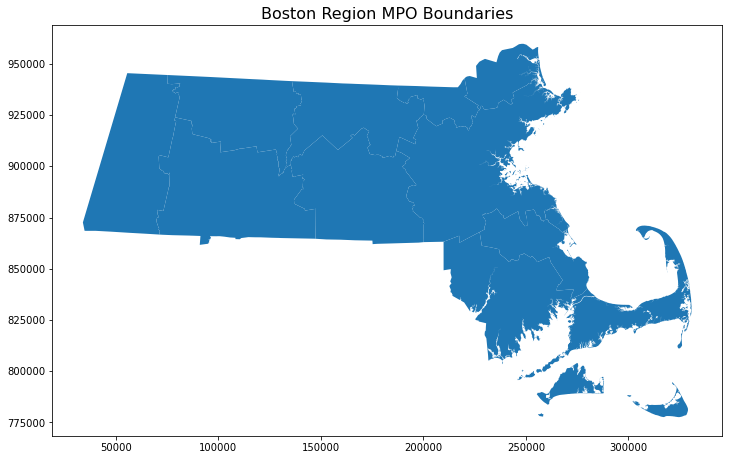

In [10]:
# Convert MPO CRS to EPSG 6491 and plot.
mpo = mpo.to_crs('epsg:6491')
mpo.plot(figsize=(12,12))
plt.title('Boston Region MPO Boundaries', fontsize=16)
plt.show()

In [11]:
# Extract only Boston Region.
boston_region = mpo.loc[mpo.MPO == 'Boston Region'].reset_index()
boston_region

,index,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,10,12,Boston Region,None,1970-01-01,DINOCCOD,2018-04-18,{3801574E-3CF1-4344-BE7C-8B2FBA431DD8},3.524379e+09,1.665026e+06,"MULTIPOLYGON (((261954.246 925125.468, 261961...."


In [12]:
# Extract ZCTAs within the Boston Region using the centroid of the ZCTAs.
boston_zcta = ma_zcta_25k[ma_zcta_25k.centroid.within(boston_region.geometry[0])].reset_index()
boston_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       159 non-null    int64   
 1   STATEFP00   159 non-null    object  
 2   ZCTA5CE00   159 non-null    object  
 3   GEOID00     159 non-null    object  
 4   CLASSFP00   159 non-null    object  
 5   MTFCC00     159 non-null    object  
 6   FUNCSTAT00  159 non-null    object  
 7   ALAND00     159 non-null    int64   
 8   AWATER00    159 non-null    int64   
 9   INTPTLAT00  159 non-null    object  
 10  INTPTLON00  159 non-null    object  
 11  PARTFLG00   159 non-null    object  
 12  geometry    159 non-null    geometry
dtypes: geometry(1), int64(3), object(9)
memory usage: 16.3+ KB


In [13]:
# View the Boston Region ZCTAs.
boston_zcta

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482...."
1,32,25,01867,2501867,B5,G6350,S,25857991,46300,+42.5351829,-071.1054234,N,"POLYGON ((234193.323 919471.462, 234167.381 91..."
2,33,25,01880,2501880,B5,G6350,S,18969895,1554312,+42.5043600,-071.0640609,N,"POLYGON ((233593.527 918646.107, 233786.679 91..."
3,34,25,01730,2501730,B5,G6350,S,34703585,424511,+42.4993313,-071.2819054,N,"POLYGON ((215991.167 913794.709, 215916.137 91..."
4,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,489,25,02030,2502030,B5,G6350,S,39440450,832120,+42.2341291,-071.2834628,N,"POLYGON ((215268.989 884982.344, 215020.550 88..."
155,490,25,02052,2502052,B5,G6350,S,37335006,608718,+42.1845991,-071.3053065,N,"POLYGON ((214616.455 880362.751, 214622.559 88..."
156,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90..."
157,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89..."


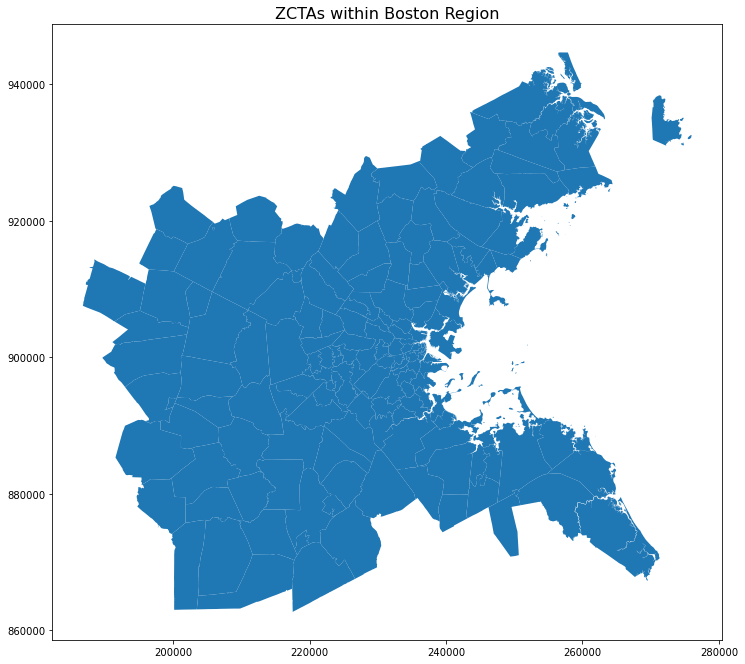

In [14]:
# Plot the Boston Region ZCTAs.
boston_zcta.plot(figsize=(12,12))
plt.title('ZCTAs within Boston Region', fontsize=16)
plt.show()

### Define Function to Read a Shapefile and Clip to Extent

In [15]:
def convert_n_clip(orig_gdf, extent_gdf):
    """
    Takes two GeoDataFrames (GDF): one to process (gdf) and one whose extent will be used to clip.
    Convert to the coordinate reference system (CRS) of the original GDF and clip to the extent of the extent GDF.
    
    Inputs:
    orig_gdf = GDF to process
    extent_gdf = GDF whose extent to use
    
    Example:
    ma_schools = convert_n_clip(usa_schools, ma_boundary)
    """
    orig_gdf = orig_gdf.to_crs(extent_gdf.crs)
    clipped_gdf = gpd.clip(orig_gdf, extent_gdf)
    return clipped_gdf

def read_n_clip(filepath, extent_gdf):
    """
    Takes a filepath for a shapefile and a GeoDataFrame (GDF).
    Reads in the file.
    Uses convert_n_clip function to convert to the coordinate reference system (CRS)
    of the GDF and clip to the extent of the GDF. 
    Returns clipped shapefile.
    
    Inputs:
    filepath = relative filepath for shapefile to read
    extent_gdf = GDF whose extent to use
    
    Example:
    ma_water = read_n_clip('./data/usa/water.shp', ma_boundary)
    """
    shapefile = gpd.read_file(filepath)
    clipped_shapefile = convert_n_clip(shapefile, extent_gdf)
    return clipped_shapefile
    

In [16]:
# read_n_clip Boston surface water.
boston_water = read_n_clip('./data/hydro25k/HYDRO25K_POLY.shp', boston_zcta)
print(boston_water.crs)
boston_water.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 12720 entries, 7279 to 71450
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MINOR_TOT   12720 non-null  object  
 1   POLY_CODE   12720 non-null  int64   
 2   PWSID       87 non-null     object  
 3   PALIS_ID    12720 non-null  int64   
 4   SOURCE      12720 non-null  object  
 5   MINOR_NUM   12720 non-null  float64 
 6   RESOLUTION  12720 non-null  object  
 7   NAME        785 non-null    object  
 8   JOIN_ID     12720 non-null  int64   
 9   COASTAL     12720 non-null  int64   
 10  SHAPE_AREA  12720 non-null  float64 
 11  SHAPE_LEN   12720 non-null  float64 
 12  geometry    12720 non-null  geometry
dtypes: float64(3), geometry(1), int64(4), object(5)
memory usage: 1.4+ MB


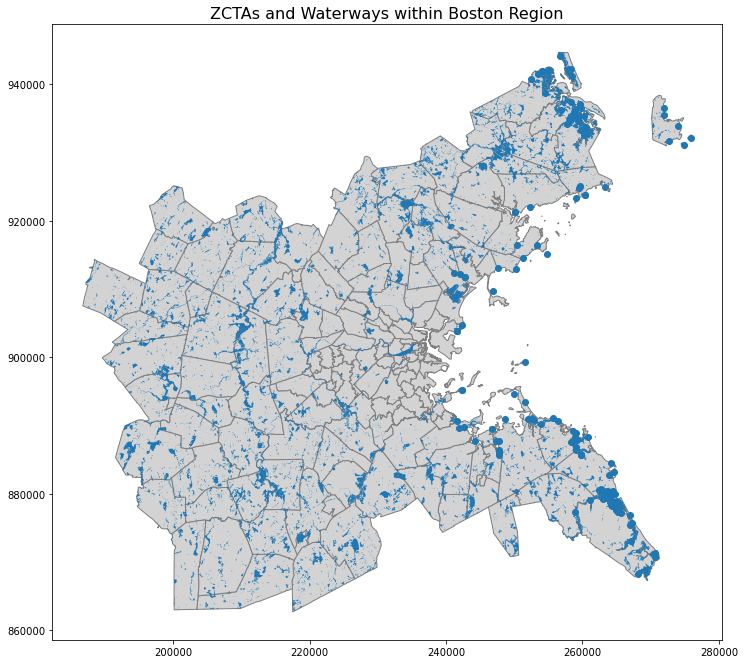

In [17]:
# Plot the Boston Region ZCTAs with surface water.
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax)
plt.title('ZCTAs and Waterways within Boston Region', fontsize=16)
plt.show()

## Find Tufts University and Boston University Locations
To find the locations of Tufts University and Boston University, the Massachusetts Colleges and Universities shapefile was imported from MassGIS as a GeoDataFrame, converted to EPSG 6491, and clipped to the extent of boston_zcta. Tufts University and Boston University were then extracted into a GeoDataGrame

In [18]:
# read_n_clip Boston colleges
colleges = read_n_clip('./data/colleges/COLLEGES_PT.shp', boston_zcta)
print(colleges.crs)
colleges.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 135 entries, 21 to 244
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   COLLEGE     135 non-null    object  
 1   CAMPUS      52 non-null     object  
 2   ADDRESS     135 non-null    object  
 3   CITY        135 non-null    object  
 4   ZIPCODE     135 non-null    object  
 5   PLUS_FOUR   22 non-null     object  
 6   GEOG_TOWN   135 non-null    object  
 7   MAIN_TEL    135 non-null    object  
 8   URL         135 non-null    object  
 9   NCES_ID     120 non-null    object  
 10  TYPE        135 non-null    object  
 11  NCES_TYPE   135 non-null    object  
 12  CATEGORY    135 non-null    object  
 13  DEGREEOFFR  135 non-null    object  
 14  AWARDSOFFR  135 non-null    object  
 15  LARGEPROG   79 non-null     object  
 16  CAMPUSSETT  135 non-null    object  
 17  CAMPUSHOUS  135 non-null    object  
 18  L_SRC       135 non-null    obj

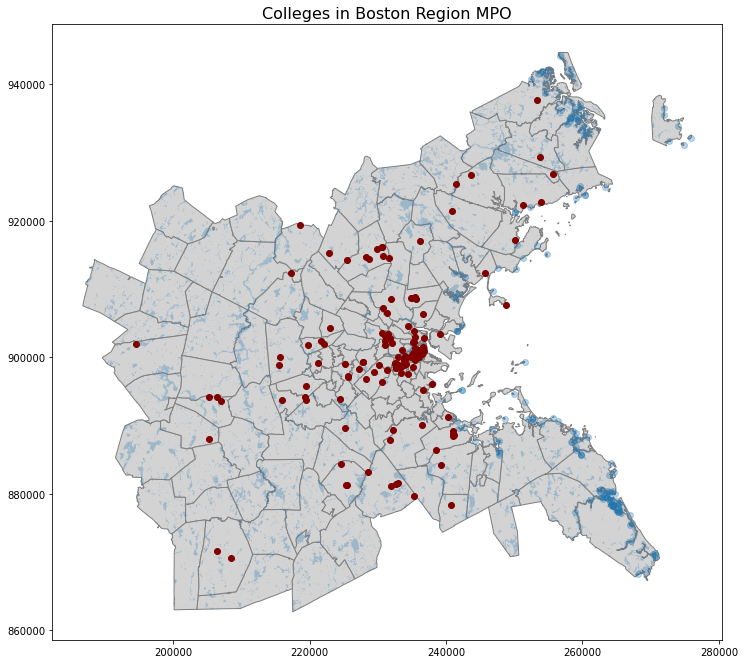

In [19]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
colleges.plot(ax=ax, color='maroon')
plt.title('Colleges in Boston Region MPO', fontsize=16)
plt.show()

In [20]:
college_list = list(colleges.COLLEGE.unique())
college_list

['Dean College',
 "Mafy's Nails Academy",
 'Tri County Regional Vocational Technical High School Adult Education',
 'Toni & Guy Hairdressing Academy',
 'Universal Technical Institute of Massachusetts Inc',
 'University of Phoenix-Boston',
 'Curry College',
 'Massachusetts Bay Community College',
 'Mansfield Beauty Schools',
 'Massachusetts School of Barbering',
 'Newbury College',
 'Boston Career Institute',
 'Boston College',
 'Harvard University',
 'Boston University School of Medicine',
 'Massachusetts College of Pharmacy and Health Science',
 'Massachusetts College of Art and Design',
 'Wentworth Institute of Technology',
 'School of the Museum of Fine Arts',
 'Boston Graduate School of Psychoanalysis Inc',
 'Blessed John Xxiii National Seminary',
 'Simmons College',
 'Northeastern University Professional Advancement Network',
 'Northeastern University',
 'New England Conservatory of Music',
 'Emmanuel College',
 'Ali May Academy',
 'Quincy College',
 'Boston Baptist College',
 'La

In [21]:
colleges_select = colleges.loc[colleges.COLLEGE.isin(['Tufts University', 'Boston University'])]
colleges_select

,COLLEGE,CAMPUS,ADDRESS,CITY,ZIPCODE,PLUS_FOUR,GEOG_TOWN,MAIN_TEL,URL,NCES_ID,TYPE,NCES_TYPE,CATEGORY,DEGREEOFFR,AWARDSOFFR,LARGEPROG,CAMPUSSETT,CAMPUSHOUS,L_SRC,geometry
136,Tufts University,Medford/Somerville Campus,419 Boston Avenue,Medford,02155,None,MEDFORD,(617) 628-5000,http://www.tufts.edu,168148,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (231416.402 906514.073)
163,Boston University,Charles River Campus,1 Silber Way,Boston,02215,None,BOSTON,(617) 353-2000,http://www.bu.edu,164988,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Less than one year certificate;One but less th...,None,City: Large,Yes,nces.ed.gov,POINT (232983.739 899977.282)
164,Tufts University,Boston Campus,145 Harrison Avenue,Boston,02111,None,BOSTON,(617) 636-7000,http://medicine.tufts.edu/,168148,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (236057.132 900054.525)


In [22]:
tufts_bu = colleges_select.iloc[[0, 1]]
tufts_bu

,COLLEGE,CAMPUS,ADDRESS,CITY,ZIPCODE,PLUS_FOUR,GEOG_TOWN,MAIN_TEL,URL,NCES_ID,TYPE,NCES_TYPE,CATEGORY,DEGREEOFFR,AWARDSOFFR,LARGEPROG,CAMPUSSETT,CAMPUSHOUS,L_SRC,geometry
136,Tufts University,Medford/Somerville Campus,419 Boston Avenue,Medford,02155,None,MEDFORD,(617) 628-5000,http://www.tufts.edu,168148,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (231416.402 906514.073)
163,Boston University,Charles River Campus,1 Silber Way,Boston,02215,None,BOSTON,(617) 353-2000,http://www.bu.edu,164988,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Less than one year certificate;One but less th...,None,City: Large,Yes,nces.ed.gov,POINT (232983.739 899977.282)


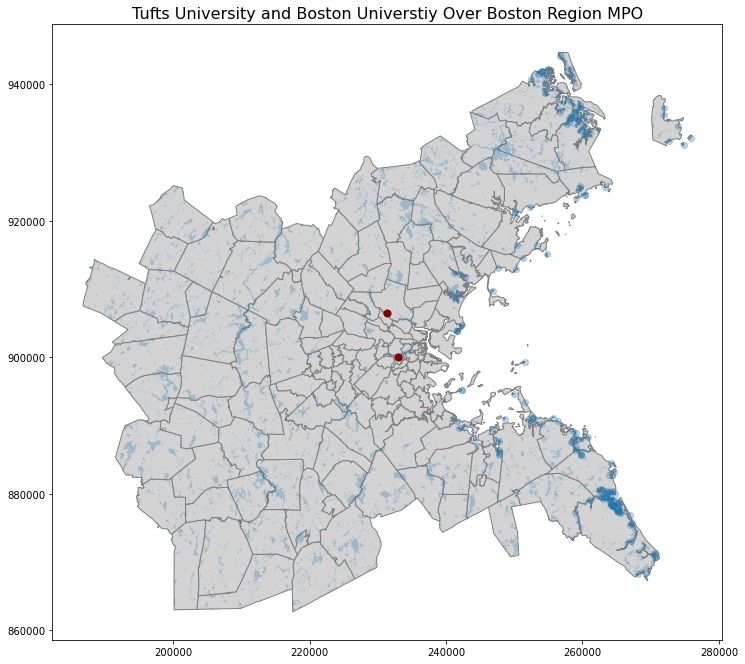

In [23]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
tufts_bu.plot(ax=ax, color='maroon', markersize=50)
plt.title('Tufts University and Boston Universtiy Over Boston Region MPO', fontsize=16)
plt.show()

## Mass Transit Routes and Stops

### MBTA Bus Stops

In [24]:
bos_bus = read_n_clip('./data/MBTA_Bus_Routes_and_Stops/MBTA_Bus_Routes_and_Stops.shp', boston_zcta)
print(bos_bus.crs)
bos_bus.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7710 entries, 0 to 7809
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   7710 non-null   int64   
 1   STOP_ID    7710 non-null   int64   
 2   STOP_NAME  7710 non-null   object  
 3   TOWN       7710 non-null   object  
 4   TOWN_ID    7710 non-null   int64   
 5   geometry   7710 non-null   geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 421.6+ KB


### MBTA Rapid Transit Routes and Stops

In [25]:
bos_rt_route = read_n_clip('./data/mbta_rapid_transit/MBTA_ARC.shp', boston_zcta)
print(bos_rt_route.crs)
bos_rt_route.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 138 entries, 0 to 137
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LINE       138 non-null    object  
 1   ROUTE      138 non-null    object  
 2   GRADE      138 non-null    int64   
 3   SHAPE_LEN  138 non-null    float64 
 4   geometry   138 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 6.5+ KB


In [26]:
bos_rt_node = read_n_clip('./data/mbta_rapid_transit/MBTA_NODE.shp', boston_zcta)
print(bos_rt_node.crs)
bos_rt_node.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 166 entries, 0 to 165
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATION   166 non-null    object  
 1   LINE      166 non-null    object  
 2   TERMINUS  166 non-null    object  
 3   ROUTE     166 non-null    object  
 4   geometry  166 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 7.8+ KB


### Commuter Rail Routes and Stops

In [27]:
bos_train_route = read_n_clip('./data/trains/TRAINS_RTE_TRAIN.shp', boston_zcta)
print(bos_train_route.crs)
bos_train_route.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13 entries, 5 to 18
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   COMM_LINE  13 non-null     object  
 1   COMMRAIL   13 non-null     object  
 2   SHAPE_LEN  13 non-null     float64 
 3   geometry   13 non-null     geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 520.0+ bytes


In [28]:
bos_train_node = read_n_clip('./data/trains/TRAINS_NODE.shp', boston_zcta)
print(bos_train_node.crs)
bos_train_node.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 201 entries, 8 to 386
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATION     201 non-null    object  
 1   C_RAILSTAT  192 non-null    object  
 2   AMTRAK      29 non-null     object  
 3   MAP_STA     109 non-null    object  
 4   LINE_BRNCH  198 non-null    object  
 5   STATE       201 non-null    object  
 6   geometry    201 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 12.6+ KB


### Map mass transit on top of base map

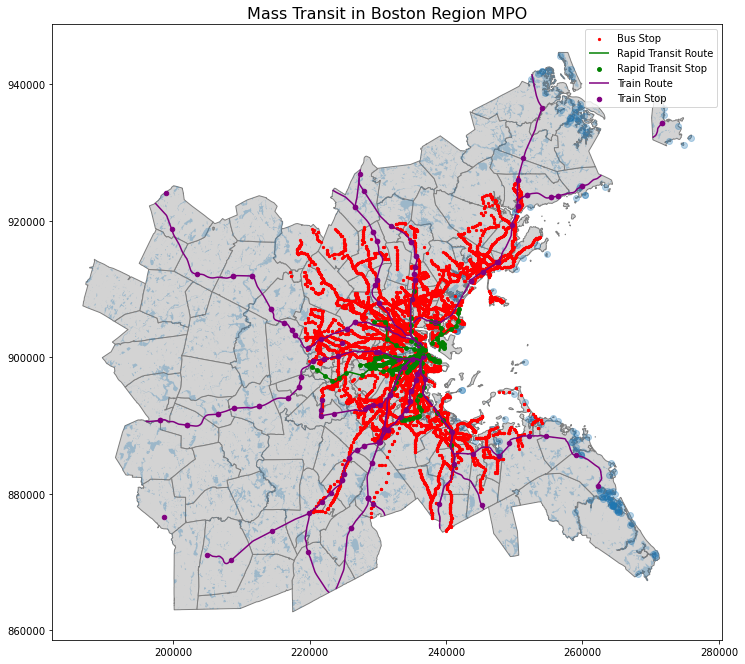

In [29]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
bos_bus.plot(ax=ax, color='red', markersize=5, label='Bus Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_train_route.plot(ax=ax, color='purple', label='Train Route')
bos_train_node.plot(ax=ax, color='purple', markersize=20, label='Train Stop')
plt.title('Mass Transit in Boston Region MPO', fontsize=16)
plt.legend()
plt.show()

## Limit Study Area to Extent of Rapid Transit

In [30]:
# Extract bounds of Boston Rapid Transit nodes.
rt_bounds = bos_rt_node.geometry.total_bounds
rt_bounds

array([220391.71303283, 884240.96758161, 241840.82146882, 909753.44856537])

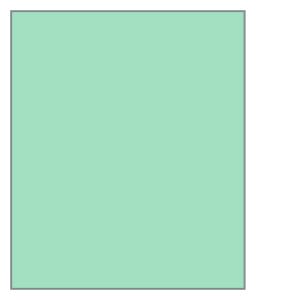

In [31]:
# Creating bounding box with shapely.geometry.box
# shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
rt_bound_box = box(rt_bounds[0], rt_bounds[1], rt_bounds[2], rt_bounds[3])
rt_bound_box

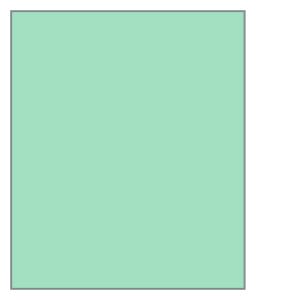

In [32]:
# Store the extent as a Shapely Polygon in a variable called graph_extent:
graph_extent = rt_bound_box.buffer(0.1, join_style=2)
graph_extent

In [33]:
# Extract Boston Region ZCTAs within the graph extent using the centroid of the ZCTAs.
rt_zcta = boston_zcta[boston_zcta.centroid.within(graph_extent)]
rt_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69 entries, 0 to 158
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       69 non-null     int64   
 1   STATEFP00   69 non-null     object  
 2   ZCTA5CE00   69 non-null     object  
 3   GEOID00     69 non-null     object  
 4   CLASSFP00   69 non-null     object  
 5   MTFCC00     69 non-null     object  
 6   FUNCSTAT00  69 non-null     object  
 7   ALAND00     69 non-null     int64   
 8   AWATER00    69 non-null     int64   
 9   INTPTLAT00  69 non-null     object  
 10  INTPTLON00  69 non-null     object  
 11  PARTFLG00   69 non-null     object  
 12  geometry    69 non-null     geometry
dtypes: geometry(1), int64(3), object(9)
memory usage: 7.5+ KB


In [34]:
rt_zcta

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482...."
4,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90..."
5,36,25,02143,2502143,B5,G6350,S,4007477,0,+42.3815721,-071.0969953,N,"MULTIPOLYGON (((234059.089 902586.579, 234073...."
6,37,25,02472,2502472,B5,G6350,S,10410330,355268,+42.3694508,-071.1779249,N,"POLYGON ((223853.273 902504.747, 223982.362 90..."
7,39,25,02464,2502464,B5,G6350,S,1447706,29494,+42.3129751,-071.2188818,N,"POLYGON ((223497.366 896100.959, 223538.895 89..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,482,25,02139,2502139,B5,G6350,S,3784723,368360,+42.3622881,-071.1037905,N,"POLYGON ((232130.866 902283.249, 232144.254 90..."
149,484,25,02474,2502474,B5,G6350,S,7903556,518211,+42.4209494,-071.1563695,N,"POLYGON ((228762.296 906831.977, 228756.803 90..."
156,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90..."
157,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89..."


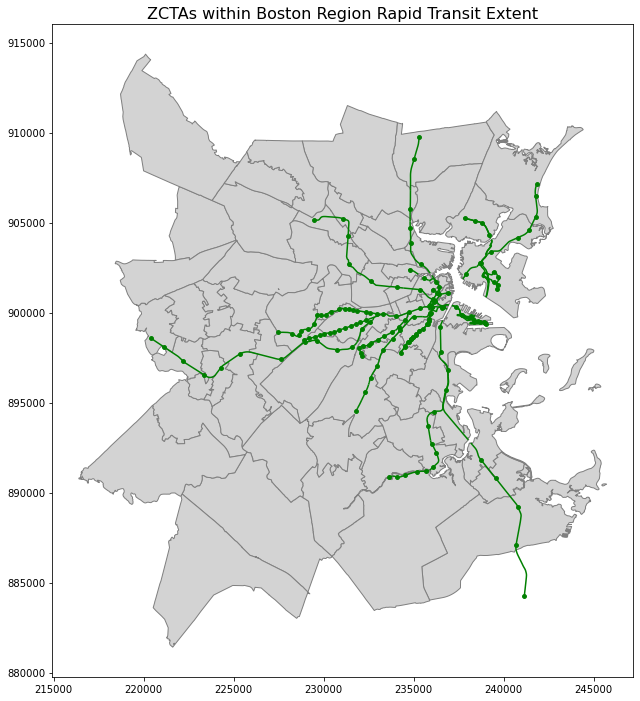

In [35]:
# Plot the Boston Region ZCTAs within graph extent.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
plt.title('ZCTAs within Boston Region Rapid Transit Extent', fontsize=16)
plt.show()

In [36]:
boston_water = gpd.clip(boston_water, rt_zcta)
bos_bus = gpd.clip(bos_bus, rt_zcta)
bos_train_route = gpd.clip(bos_train_route, rt_zcta)
bos_train_node = gpd.clip(bos_train_node, rt_zcta)

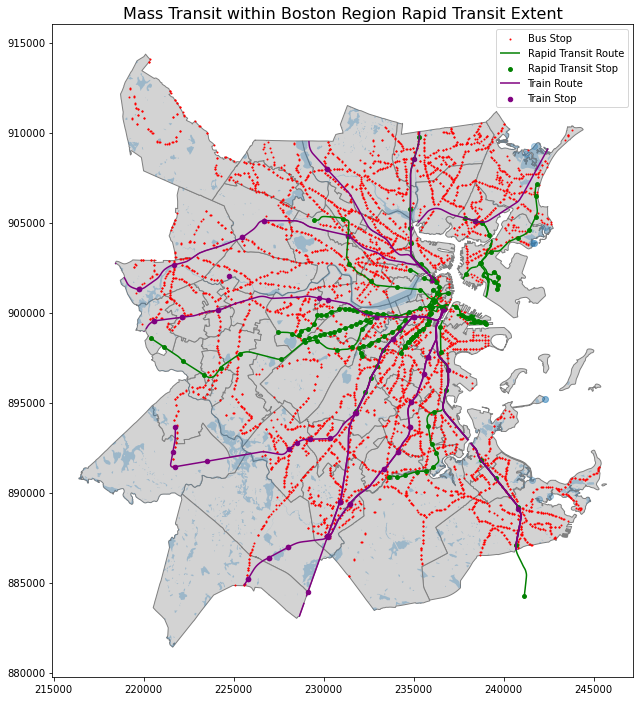

In [37]:
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
bos_bus.plot(ax=ax, color='red', markersize=1, label='Bus Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_train_route.plot(ax=ax, color='purple', label='Train Route')
bos_train_node.plot(ax=ax, color='purple', markersize=20, label='Train Stop')
plt.title('Mass Transit within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

#### TEST CODE

bos_bus.head()

bos_bus_latlong = bos_bus.to_crs('epsg:4326')
bos_bus_latlong

bos_bus['latitude'] = bos_bus_latlong.geometry.y
bos_bus['longitude'] = bos_bus_latlong.geometry.x
bos_bus.head()

m_1 = folium.Map(location=[42.32, -71.0589], tiles='openstreetmap', zoom_start=20)
mc_1 = MarkerCluster()
for idx, row in bos_bus.iterrows():
    mc_1.add_child(folium.Marker([row['latitude'], row['longitude']], icon=folium.Icon(color='red', icon='bus')))

mc_1.add_to(m_1)
m_1

### Public Transit Nodes per ZCTA

In [38]:
def count_nodes(nodes_gdf, polygon_gdf, polygon_col, count_col):
    """
    
    """
    spatial_join = gpd.sjoin(nodes_gdf, polygon_gdf, how='left', op='within')
    nodes_count = spatial_join[polygon_col].value_counts().reset_index()
    nodes_count.columns = [polygon_col, count_col]
    return nodes_count

In [39]:
zcta_bus_count = count_nodes(bos_bus, rt_zcta, 'ZCTA5CE00', 'bus_stop_count')
zcta_bus_count

,ZCTA5CE00,bus_stop_count
0,02169,334
1,02148,265
2,02155,242
3,02136,179
4,02151,176
...,...,...
62,02142,7
63,02114,5
64,02199,3
65,02113,1


In [40]:
zcta_rt_count = count_nodes(bos_rt_node, rt_zcta, 'ZCTA5CE00', 'rt_stop_count')
zcta_rt_count

,ZCTA5CE00,rt_stop_count
0,02118,15
1,02210,13
2,02128,11
3,02115,9
4,02215,9
5,02135,9
6,02446,9
7,02445,8
8,02111,8
9,02130,7


In [41]:
zcta_train_count = count_nodes(bos_train_node, rt_zcta, 'ZCTA5CE00', 'train_stop_count')
zcta_train_count

,ZCTA5CE00,train_stop_count
0,02222,10
1,02136,10
2,02111,9
3,02026,5
4,02478,4
5,02126,4
6,02125,4
7,02116,4
8,02120,3
9,02492,3


### Define function to merge multiple DataFrames

In [85]:
def multimerge(left_gdf, gdf_list, on_col, how):
    """
    Takes a base GeoDataFrame and merges with a list of GeoDataFrames 
    on the specified column and with the specified 'how'.
    Assumes on_col exists across all GDFs.
    
    Inputs:
    left_gdf = base GDF
    gdf_list = list of GDFS, e.g. [gdf1, gdf2, gdf3]
    on_col = string of column name (same across GDFs), e.g. 'name'
    how = how argument, e.g. 'left'
    
    Example:
    town_schools = multimerge(town, [elementary, middle, high], 'town_name', 'left')
    """
    merge_gdf = left_gdf.copy()
    for i in range(len(gdf_list)):
        merge_gdf = merge_gdf.merge(gdf_list[i], on=[on_col], how=how)
    return merge_gdf

In [92]:
count_list = [zcta_bus_count, zcta_rt_count, zcta_train_count]
zcta_nodes = multimerge(rt_zcta, count_list, 'ZCTA5CE00', 'left').fillna(0)
zcta_nodes

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,bus_stop_count,rt_stop_count,train_stop_count
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482....",53.0,0.0,2.0
1,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90...",23.0,1.0,0.0
2,36,25,02143,2502143,B5,G6350,S,4007477,0,+42.3815721,-071.0969953,N,"MULTIPOLYGON (((234059.089 902586.579, 234073....",108.0,0.0,0.0
3,37,25,02472,2502472,B5,G6350,S,10410330,355268,+42.3694508,-071.1779249,N,"POLYGON ((223853.273 902504.747, 223982.362 90...",99.0,0.0,1.0
4,39,25,02464,2502464,B5,G6350,S,1447706,29494,+42.3129751,-071.2188818,N,"POLYGON ((223497.366 896100.959, 223538.895 89...",22.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,482,25,02139,2502139,B5,G6350,S,3784723,368360,+42.3622881,-071.1037905,N,"POLYGON ((232130.866 902283.249, 232144.254 90...",81.0,1.0,0.0
65,484,25,02474,2502474,B5,G6350,S,7903556,518211,+42.4209494,-071.1563695,N,"POLYGON ((228762.296 906831.977, 228756.803 90...",79.0,0.0,0.0
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",13.0,8.0,9.0
67,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89...",97.0,7.0,3.0


In [93]:
zcta_nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69 entries, 0 to 68
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             69 non-null     int64   
 1   STATEFP00         69 non-null     object  
 2   ZCTA5CE00         69 non-null     object  
 3   GEOID00           69 non-null     object  
 4   CLASSFP00         69 non-null     object  
 5   MTFCC00           69 non-null     object  
 6   FUNCSTAT00        69 non-null     object  
 7   ALAND00           69 non-null     int64   
 8   AWATER00          69 non-null     int64   
 9   INTPTLAT00        69 non-null     object  
 10  INTPTLON00        69 non-null     object  
 11  PARTFLG00         69 non-null     object  
 12  geometry          69 non-null     geometry
 13  bus_stop_count    69 non-null     float64 
 14  rt_stop_count     69 non-null     float64 
 15  train_stop_count  69 non-null     float64 
dtypes: float64(3), geome

In [94]:
zcta_nodes['nodes_count'] = zcta_nodes.bus_stop_count + zcta_nodes.rt_stop_count + zcta_nodes.train_stop_count
zcta_nodes

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,bus_stop_count,rt_stop_count,train_stop_count,nodes_count
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482....",53.0,0.0,2.0,55.0
1,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90...",23.0,1.0,0.0,24.0
2,36,25,02143,2502143,B5,G6350,S,4007477,0,+42.3815721,-071.0969953,N,"MULTIPOLYGON (((234059.089 902586.579, 234073....",108.0,0.0,0.0,108.0
3,37,25,02472,2502472,B5,G6350,S,10410330,355268,+42.3694508,-071.1779249,N,"POLYGON ((223853.273 902504.747, 223982.362 90...",99.0,0.0,1.0,100.0
4,39,25,02464,2502464,B5,G6350,S,1447706,29494,+42.3129751,-071.2188818,N,"POLYGON ((223497.366 896100.959, 223538.895 89...",22.0,0.0,0.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,482,25,02139,2502139,B5,G6350,S,3784723,368360,+42.3622881,-071.1037905,N,"POLYGON ((232130.866 902283.249, 232144.254 90...",81.0,1.0,0.0,82.0
65,484,25,02474,2502474,B5,G6350,S,7903556,518211,+42.4209494,-071.1563695,N,"POLYGON ((228762.296 906831.977, 228756.803 90...",79.0,0.0,0.0,79.0
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",13.0,8.0,9.0,30.0
67,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89...",97.0,7.0,3.0,107.0


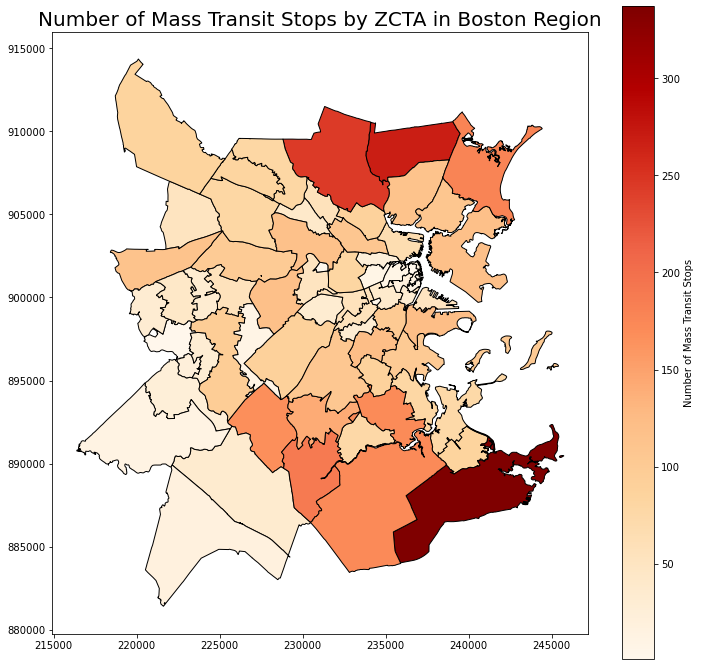

In [95]:
# Map the number of transit nodes in each ZCTA.
ax = zcta_nodes.plot(column = 'nodes_count',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'OrRd',
                      figsize = (12, 12),
                      legend_kwds={'label': "Number of Mass Transit Stops"})
plt.title('Number of Mass Transit Stops by ZCTA in Boston Region', fontsize = 20)
plt.show()

In [96]:
# Calculate node density in nodes/sqkm.
zcta_nodes['nodes_density'] = zcta_nodes.nodes_count/zcta_nodes.area*(10**6)
zcta_nodes.sort_values(by='nodes_density', ascending=False).head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,bus_stop_count,rt_stop_count,train_stop_count,nodes_count,nodes_density
68,495,25,02222,2502222,B5,G6350,S,77896,0,+42.3664695,-071.0624939,N,"POLYGON ((235839.790 902134.685, 235852.488 90...",0.0,0.0,10.0,10.0,128.417764
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",13.0,8.0,9.0,30.0,39.540383
55,378,25,02118,2502118,B5,G6350,S,2747439,0,+42.3378630,-071.0708157,N,"POLYGON ((235192.725 898164.265, 235174.169 89...",87.0,15.0,1.0,103.0,37.491925
36,253,25,02109,2502109,B5,G6350,S,427819,0,+42.3626531,-071.0538044,N,"MULTIPOLYGON (((236437.338 900792.044, 236429....",13.0,1.0,0.0,14.0,33.228131
32,249,25,02119,2502119,B5,G6350,S,4153196,0,+42.3238812,-071.0853318,N,"POLYGON ((235115.975 898168.657, 235148.036 89...",120.0,2.0,0.0,122.0,29.376895


In [97]:
zcta_nodes.nodes_density.describe()

count     69.000000
mean      16.051534
std       16.371549
min        0.478677
25%        8.319632
50%       13.907207
75%       20.223958
max      128.417764
Name: nodes_density, dtype: float64

In [99]:
# Outlier detected for ZCTA 02222, which contains only TD Garden.
# Value for nodes_density set to median value.
zcta_nodes.loc[68, 'nodes_density'] = zcta_nodes.nodes_density.median()
zcta_nodes.sort_values(by='nodes_density', ascending=False).head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,bus_stop_count,rt_stop_count,train_stop_count,nodes_count,nodes_density
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",13.0,8.0,9.0,30.0,39.540383
55,378,25,02118,2502118,B5,G6350,S,2747439,0,+42.3378630,-071.0708157,N,"POLYGON ((235192.725 898164.265, 235174.169 89...",87.0,15.0,1.0,103.0,37.491925
36,253,25,02109,2502109,B5,G6350,S,427819,0,+42.3626531,-071.0538044,N,"MULTIPOLYGON (((236437.338 900792.044, 236429....",13.0,1.0,0.0,14.0,33.228131
32,249,25,02119,2502119,B5,G6350,S,4153196,0,+42.3238812,-071.0853318,N,"POLYGON ((235115.975 898168.657, 235148.036 89...",120.0,2.0,0.0,122.0,29.376895
2,36,25,02143,2502143,B5,G6350,S,4007477,0,+42.3815721,-071.0969953,N,"MULTIPOLYGON (((234059.089 902586.579, 234073....",108.0,0.0,0.0,108.0,26.951361


In [100]:
zcta_nodes.nodes_density.describe()

count    69.000000
mean     14.391961
std       8.923093
min       0.478677
25%       8.319632
50%      13.907207
75%      20.162023
max      39.540383
Name: nodes_density, dtype: float64

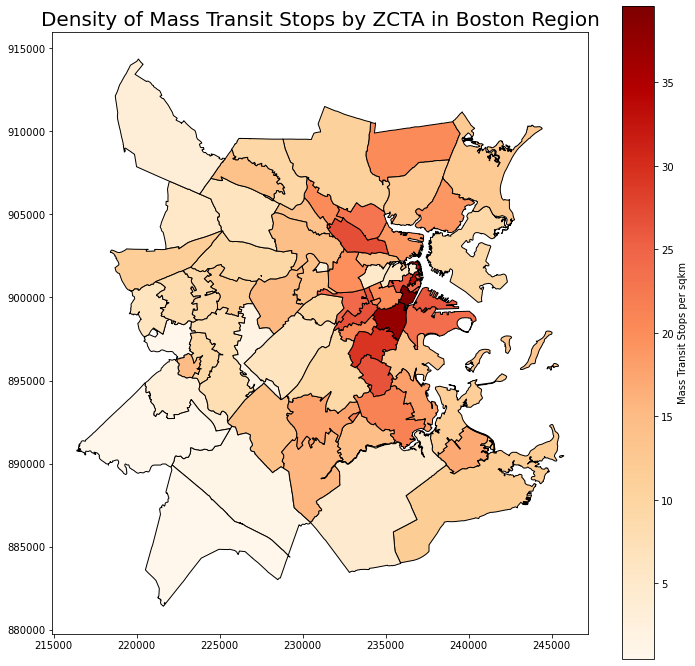

In [101]:
# Map the density of transit nodes in each ZCTA.
ax = zcta_nodes.plot(column = 'nodes_density',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'OrRd',
                      figsize = (12, 12),
                      legend_kwds={'label': "Mass Transit Stops per sqkm"})
plt.title('Density of Mass Transit Stops by ZCTA in Boston Region', fontsize = 20)
plt.show()

## Distance to Necessities/Amenities
Amenities are defined as food/groceries, healthcare institutions (acute care, urgent care, hospitals, etc.), safety (firestations)

### Create graph_extent in latitude-longitude to use with `OSMnx`

In [51]:
# Extract bounds of Boston Rapid Transit nodes.
rt_bounds_latlong = bos_rt_node.to_crs('epsg:4326').geometry.total_bounds
rt_bounds_latlong

array([-71.25255434,  42.20753726, -70.99166451,  42.4375046 ])

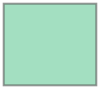

In [52]:
# Creating bounding box with shapely.geometry.box
# shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
rt_bound_box_latlong = box(rt_bounds_latlong[0], rt_bounds_latlong[1], rt_bounds_latlong[2], rt_bounds_latlong[3])
rt_bound_box_latlong

<class 'shapely.geometry.polygon.Polygon'>


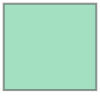

In [53]:
# Store the extent as a Shapely Polygon in a variable called graph_extent:
graph_extent_latlong = rt_bound_box_latlong.buffer(0.1, join_style=2)
print(type(graph_extent_latlong))
graph_extent_latlong

### Groceries within extent

In [54]:
grocery_tags = {'shop':['supermarket', 'greengrocer', 'bakery', 'butcher', 'deli', 'dairy', 'farm', 'seafood', 'wholesale']}
grocery = ox.geometries_from_polygon(graph_extent_latlong, grocery_tags)
grocery = convert_n_clip(grocery, rt_zcta)
grocery

,unique_id,osmid,element_type,brand,brand:wikidata,brand:wikipedia,name,note,shop,geometry,...,name:zh-Hant,building:colour,building:min_level,roof:colour,UPDATE_DAT,operator:wikidata,operator:wikipedia,landuse,ways,type
0,node/314092543,314092543,node,Stop & Shop,Q3658429,en:Stop & Shop,Stop & Shop,store new since 2006 aerial imagery,supermarket,POINT (235831.905 897407.979),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/355795164,355795164,node,NaN,NaN,NaN,La Ronga Bakery & Delicatessen,NaN,bakery,POINT (232151.416 903802.162),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/431377975,431377975,node,NaN,NaN,NaN,Quebrada Baking Co.,NaN,bakery,POINT (229412.784 906211.019),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/460001186,460001186,node,NaN,NaN,NaN,Star Market,NaN,supermarket,POINT (231430.529 904430.448),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,node/460211013,460211013,node,NaN,NaN,NaN,Star Market,NaN,supermarket,POINT (228901.367 902823.634),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,way/552434369,552434369,way,NaN,NaN,NaN,BJ's Wholesale Club,NaN,wholesale,"POLYGON ((240204.432 887001.522, 240214.933 88...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361,way/816585252,816585252,way,NaN,NaN,NaN,Super Stop & Shop,NaN,supermarket,"POLYGON ((237161.152 893719.100, 237164.400 89...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,way/886888575,886888575,way,NaN,NaN,NaN,Vitória Meat Market,NaN,butcher,"POLYGON ((236908.756 907681.259, 236926.949 90...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,retail,NaN,NaN
365,relation/5151441,5151441,relation,Wegmans,Q11288478,NaN,Wegmans,NaN,supermarket,"POLYGON ((228581.235 884140.035, 228582.913 88...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[345868369, 345868370]",multipolygon


### Health services within extent

In [55]:
comm_health = read_n_clip('./data/chcs/CHCS_PT.shp', rt_zcta)
comm_health

,SITE_NAME,SITE_TYPE,ADMIN_ONLY,ADDRESS,ADDRESS_OT,MAIL_CITY,ZIP,PO_BOX,TOWN,TOWN_ID,SATELLITE,EYE,DENTAL,METHOD,GIS_ID,MCHC_CODE,MAD_ID,geometry
1,Chinatown Clinic,NOS,N,885 Washington Street,None,Boston,02111,None,BOSTON,35,Y,N,N,G,S99,SCCHC,35145770,POINT (235848.295 899811.714)
3,St. Francis House Clinic,HOMELESS,N,39 Boylston Street,None,Boston,02116,None,BOSTON,35,Y,N,N,G,S101,BHCHP,35018316,POINT (235955.316 900313.222)
8,Teen Health Center at Cambridge Rindge and Lat...,SCHOOL,N,459 Broadway,None,Cambridge,02138,None,CAMBRIDGE,49,Y,N,N,G,S106,CHA,3624789,POINT (231966.092 902732.932)
9,The Great Hall,NOS,N,6 Norfolk Street,None,Dorchester,02124,None,BOSTON,35,Y,N,N,G,S107,CSHC,35103391,POINT (235304.694 893366.484)
11,Upham's Corner Adolescent Health & WIC,NOS,N,500 Columbia Road,None,Dorchester,02125,None,BOSTON,35,Y,N,N,G,S111,UCHC,35035283,POINT (235647.822 896122.920)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,NEW Health at Charlestown High School,SCHOOL,N,240 Medford Street,None,Charlestown,02129,None,BOSTON,35,Y,N,N,G,None,NEWH,35093717,POINT (236147.141 903383.303)
182,South Boston Health Seaport,NOS,N,505 Congress Street,None,South Boston,02210,None,BOSTON,35,Y,N,N,G,None,SBCHC,35344584,POINT (237814.914 899819.147)
183,Dr. Gerald Hass Center,SCHOOL,N,400 Shawmut Avenue,Blackstone Innovation School,Boston,02118,None,BOSTON,35,Y,N,N,G,None,SECHC,35169641,POINT (235185.345 898966.163)
186,Whittier Street Health Center @ Quincy Commons,NOS,N,278 Blue Hill Avenue,None,Roxbury,02119,None,BOSTON,35,Y,N,N,G,None,WSHC,35351824,POINT (234751.256 896116.921)


In [56]:
hospitals = read_n_clip('./data/acute_care_hospitals/HOSPITALS_PT.shp', rt_zcta)
hospitals

,IDNUMBER,DPHID,NAME,SHORTNAME,ADDRESS,TOWN,GEOG_TOWN,ZIPCODE,CHIAREGION,TELEPHONE,...,TAXSTATUS,BEDCOUNT,ER_STATUS,TRAUMA_ADU,TRAUMA_PED,SPEPUBFUND,FYE,MADID,EMSREGION,geometry
0,2069,2069,Beth Israel Deaconess Medical Center East,BIDMC East,330 Brookline Avenue,Boston,BOSTON,02215,Metro Boston,(617) 667-7000,...,Non-profit,248,N,None,None,Not Applicable,2017-09-30,35022096,4,POINT (232494.091 898890.122)
1,2085,2085,Steward St. Elizabeth's Medical Center,St. Elizabeth's Medical Center,736 Cambridge Street,Brighton,BOSTON,02135,Metro Boston,(617) 789-3000,...,For profit,252,Y,None,None,Not Applicable,2017-12-31,35156980,4,POINT (229003.958 899958.291)
2,2299,2299,Tufts Medical Center,Tufts Medical Center,800 Washington Street,Boston,BOSTON,02111,Metro Boston,(617) 636-5000,...,Non-profit,415,Y,Level 1,Level 1,Not Applicable,2017-09-30,35145764,4,POINT (235963.109 899998.149)
4,2167,2167,Massachusetts Eye and Ear Infirmary,Massachusetts Eye and Ear Infirmary,243 Charles Street,Boston,BOSTON,02114,Metro Boston,(617) 523-7900,...,Non-profit,41,Y,None,None,Not Applicable,2017-09-30,35163139,4,POINT (235396.614 901452.905)
5,2316,2316,Shriners Hospital For Children - Boston,Shriners Boston,51 Blossom Street,Boston,BOSTON,02114,Metro Boston,(617) 722-3000,...,Non-profit,30,N,None,None,Not Applicable,2017-12-31,35016066,4,POINT (235713.701 901489.419)
6,2168,2168,Massachusetts General Hospital,Massachusetts General Hospital,55 Fruit Street,Boston,BOSTON,02114,Metro Boston,(617) 726-2000,...,Non-profit,1035,Y,Level 1,Level 1,Not Applicable,2017-09-30,35155723,4,POINT (235522.402 901501.524)
7,2071,2071,Mount Auburn Hospital,Mount Auburn Hospital,330 Mount Auburn Street,Cambridge,CAMBRIDGE,02138,Metro Boston,(617) 492-3500,...,Non-profit,217,Y,None,None,Not Applicable,2017-09-30,3619685,4,POINT (230124.615 902663.512)
8,2108,2108,CHA Cambridge Hospital,Cambridge Hospital,1493 Cambridge Street,Cambridge,CAMBRIDGE,02139,Metro Boston,(617) 665-1000,...,Municipal,189,Y,None,None,DSTI,2017-06-30,3618038,4,POINT (232587.749 902768.034)
9,2046,2046,CHA Everett Hospital,Everett Hospital,103 Garland Street,Everett,EVERETT,02149,Metro Boston,(617) 389-6270,...,Municipal,162,Y,None,None,DSTI,None,3508585,3,POINT (237885.457 906637.049)
10,2038,2038,Lawrence Memorial Hospital of Medford,Lawrence Memorial Hospital of Medford,170 Governors Avenue,Medford,MEDFORD,02155,Metro Boston,(781) 306-6000,...,Non-profit,98,Y,None,None,CHART,2017-09-30,2574987,3,POINT (231971.181 908456.113)


In [57]:
health_tags = {'healthcare':True, 'amenity':['clinic', 'doctors', 'dentist', 'health_post', 'hospital', 'pharmacy']}
healthcare = ox.geometries_from_polygon(graph_extent_latlong, health_tags)
healthcare = convert_n_clip(healthcare, rt_zcta)
healthcare

,unique_id,osmid,element_type,attribution,source,geometry,addr:city,addr:housenumber,addr:state,addr:street,...,massgis:OS_ID,massgis:OWNER_ABRV,massgis:OWNER_TYPE,massgis:POLY_ID,massgis:PRIM_PURP,massgis:PUB_ACCESS,massgis:SITE_NAME,massgis:SOURCE_MAP,massgis:TOWN_ID,protected
0,node/61348061,61348061,node,Office of Geographic and Environmental Informa...,massgis_import_v0.1_20071008193615,POINT (228225.230 899815.766),Brighton,438,MA,Washington Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/257489564,257489564,node,NaN,NaN,POINT (235408.823 901449.034),Boston,243,NaN,Charles Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/257489648,257489648,node,NaN,NaN,POINT (235923.447 900015.140),Boston,755,NaN,Washington Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/358278209,358278209,node,NaN,NaN,POINT (233490.267 891124.319),Mattapan,1575,NaN,Blue Hill Avenue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,node/367777794,367777794,node,NaN,USGS Geonames,POINT (232386.086 898796.067),NaN,NaN,MA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,way/852078315,852078315,way,NaN,NaN,"POLYGON ((228921.000 897382.629, 229019.391 89...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
516,relation/63951,63951,relation,NaN,NaN,"POLYGON ((235068.820 898309.957, 235074.973 89...",Boston,1,NaN,Boston Medical Center Place,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517,relation/64055,64055,relation,NaN,NaN,"POLYGON ((233234.301 896651.614, 233222.175 89...",NaN,41,NaN,Dimock Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518,relation/65264,65264,relation,NaN,NaN,"POLYGON ((228905.589 897363.960, 228910.138 89...",Chestnut Hill,850,NaN,Boylston Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Public services within extent

In [58]:
fire = read_n_clip('./data/firestations_pt/FIRESTATIONS_PT_MEMA.shp', rt_zcta)
fire

,NAME,OFFICE,ADDRESS,CITY,STATE,ZIP,L_SRC,SOURCE,L_DATE,geometry
5,MILTON FIRE DEPARTMENT,DEPT E 4,815 Blue Hill Ave.,MILTON,MA,01286,MAPC,MEMA,2006-08-16,POINT (232280.004 887730.431)
6,MILTON FIRE DEPARTMENT,Station 1- Headquarters,515 Canton Avenue,MILTON,MA,02186,MAPC,MEMA,2006-08-16,POINT (234642.734 889410.311)
7,MILTON FIRE DEPARTMENT,Station E 2,525 Adams Street,MILTON,MA,02186,MAPC,MEMA,2006-08-16,POINT (237885.224 889826.071)
38,REVERE FIRE DEPARTMENT,Engine 1,13 Walden Street,REVERE,MA,02151,MAPC,MEMA,2006-08-16,POINT (241572.264 906537.411)
39,REVERE FIRE DEPARTMENT,Engine 3,929 Winthrop Avenue,REVERE,MA,02151,MAPC,MEMA,2006-08-16,POINT (242387.724 904981.381)
...,...,...,...,...,...,...,...,...,...,...
705,WALTHAM FIRE DEPARTMENT,Engine 3 Station,67 Willow Street,WALTHAM,MA,02453,MAPC,MEMA,2005-08-10,POINT (223191.084 902713.891)
707,WALTHAM FIRE DEPARTMENT,Engine 4 Station,35 Prospect Street,WALTHAM,MA,02453,MAPC,MEMA,2005-08-10,POINT (220852.664 902712.171)
708,WATERTOWN FIRE DEPARTMENT,Station 2,564 Mount Auburn Street,WATERTOWN,MA,02472,MAPC,MEMA,2005-08-09,POINT (228010.184 902282.641)
709,WATERTOWN FIRE DEPARTMENT,Headquarters,99 Main Street,WATERTOWN,MA,02472,MAPC,MEMA,2005-08-09,POINT (225815.774 901897.991)


In [59]:
police = read_n_clip('./data/policestations/POLICESTATIONS_PT_MEMA.shp', rt_zcta)
police

,NAME,ADDRESS,CITY,STATE,ZIP,JURISDIC,L_SRC,SOURCE,L_DATE,geometry
6,"STATE POLICE STATION H-7, MILTON",685 HILLSIDE STREET,MILTON,MA,02186,STATE,MAPC,MEMA,2006-09-12,POINT (233598.434 885007.271)
42,BOSTON POLICE DEPARTMENT DISTRICT E-5,1708 CENTRE STREET,BOSTON,MA,02132,LOCAL,MEMA,CITY,2006-09-12,POINT (229001.867 892986.812)
43,BOSTON POLICE DEPARTMENT DISTRICTS A-1 AND A-15,40 NEW SUDBURY STREET,BOSTON,MA,02114,LOCAL,MEMA,CITY,2006-09-12,POINT (236217.474 901349.051)
44,BOSTON POLICE DEPARTMENT DISTRICT B-2,2400 WASHINGTON STREET,BOSTON,MA,02119,LOCAL,MEMA,CITY,2014-03-01,POINT (234279.794 897624.521)
45,BOSTON POLICE DEPARTMENT DISTRICT C-11,40 GIBSON STREET,BOSTON,MA,02122,LOCAL,MEMA,CITY,2006-09-12,POINT (236357.494 894265.901)
46,BOSTON POLICE DEPARTMENT DISTRICT B-3,1165 BLUE HILL AVENUE,BOSTON,MA,02124,LOCAL,MEMA,CITY,2006-09-12,POINT (233676.264 892770.231)
47,BOSTON POLICE DEPARTMENT DISTRICT C-6,101 WEST BROADWAY,BOSTON,MA,02127,LOCAL,MEMA,CITY,2006-09-12,POINT (236673.444 899054.851)
48,BOSTON POLICE DEPARTMENT DISTRICT A-7,69 PARIS STREET,BOSTON,MA,02128,LOCAL,MEMA,CITY,2006-09-12,POINT (237986.124 902383.951)
49,BOSTON POLICE DEPARTMENT DISTRICT E-13,3347 WASHINGTON STREET,BOSTON,MA,02130,LOCAL,MEMA,CITY,2006-09-12,POINT (232597.684 895542.431)
50,BOSTON POLICE DEPARTMENT DISTRICT E-18,1249 HYDE PARK AVENUE,BOSTON,MA,02136,LOCAL,MEMA,CITY,2006-09-12,POINT (231002.364 889619.631)


In [60]:
post_tags = {'amenity':'post_office'}
post = ox.geometries_from_polygon(graph_extent_latlong, post_tags)
post = convert_n_clip(post, rt_zcta)
post

,unique_id,osmid,element_type,amenity,name,geometry,ele,gnis:county_id,gnis:created,gnis:feature_id,...,toilets:wheelchair,heritage,building:part,gnis:County,gnis:County_num,gnis:ST_num,gnis:county_name,gnis:id,operator:type,operator:wikipedia
0,node/355792796,355792796,node,post_office,The UPS Store,POINT (232408.776 903735.443),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/358276159,358276159,node,post_office,Newton Post Office,POINT (225553.556 897850.211),45,017,04/01/1989,618865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/358276166,358276166,node,post_office,Brookline Village Post Office,POINT (231473.616 898082.271),9,021,02/01/1994,618875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,node/358277363,358277363,node,post_office,United States Post Office,POINT (234370.230 899661.820),6,025,01/15/2003,1972055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,node/358277485,358277485,node,post_office,Chelsea Post Office,POINT (238154.636 904665.034),8,025,01/15/2003,1972281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,way/42645062,42645062,way,post_office,Waltham Post Office,"POLYGON ((221315.763 902874.398, 221315.244 90...",21,017,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,way/42680659,42680659,way,post_office,NaN,"POLYGON ((221601.971 902294.803, 221599.885 90...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,way/312345628,312345628,way,post_office,West Roxbury Post Office,"POLYGON ((228544.227 892955.338, 228576.555 89...",45,NaN,NaN,NaN,...,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,way/427505297,427505297,way,post_office,Cambridge Post Office,"POLYGON ((231087.469 902636.738, 231084.479 90...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
ps_tags = {'amenity':['fire_station', 'police', 'post_office']}
public_service = ox.geometries_from_polygon(graph_extent_latlong, ps_tags)
public_service = convert_n_clip(public_service, rt_zcta)
public_service

,unique_id,osmid,element_type,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,amenity,attribution,...,heritage,building:part,gnis:County,gnis:County_num,gnis:ST_num,gnis:id,contact:facebook,contact:twitter,operator:type,operator:wikipedia
0,node/257493571,257493571,node,Boston,1,02108,MA,Ashburton Place,police,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/257493592,257493592,node,Boston,1249,02136,MA,Hyde Park Avenue,police,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/257493598,257493598,node,Boston,69,02128,MA,Paris Street,police,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/257493604,257493604,node,Medford,520,02155,MA,Fellsway,police,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,node/257493622,257493622,node,Boston,1708,02132,MA,Centre Street,police,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,way/711030295,711030295,way,Belmont,40,02478,MA,Woodland Street,police,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
442,way/754442739,754442739,way,Watertown,564,02472,MA,Mount Auburn Street,fire_station,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
443,way/754442740,754442740,way,Watertown,589,02472,MA,Mount Auburn Street,post_office,NaN,...,NaN,NaN,Middlesex,017,589,1972510,NaN,NaN,NaN,NaN
445,way/849606613,849606613,way,NaN,NaN,NaN,NaN,NaN,police,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/MassStatePolice/,NaN,NaN,NaN


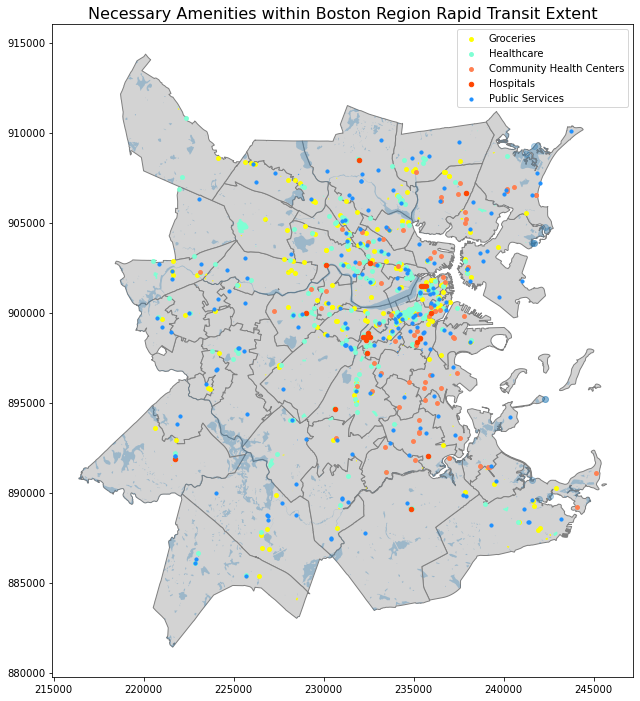

In [62]:
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
grocery.plot(ax=ax, markersize=15, color='yellow', label='Groceries')
healthcare.plot(ax=ax, markersize=15, color='aquamarine', label='Healthcare')
comm_health.plot(ax=ax, markersize=15, color='coral', label='Community Health Centers')
hospitals.plot(ax=ax, markersize=20, color='orangered', label='Hospitals')
public_service.plot(ax=ax, markersize=10, color='dodgerblue', label='Public Services')
plt.title('Necessary Amenities within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

### Necessities/Amenities per ZCTA

In [63]:
grocery_count = count_nodes(grocery, rt_zcta, 'ZCTA5CE00', 'grocery_count')
grocery_count

,ZCTA5CE00,grocery_count
0,02138,13
1,02143,11
2,02169,10
3,02130,9
4,02446,8
...,...,...
57,02124,1
58,02119,1
59,02131,1
60,02466,1


In [64]:
healthcare_count = count_nodes(healthcare, rt_zcta, 'ZCTA5CE00', 'healthcare_count')
healthcare_count

,ZCTA5CE00,healthcare_count
0,02116,35
1,02130,20
2,02115,18
3,02135,15
4,02138,13
5,02139,12
6,02143,12
7,02215,11
8,02114,10
9,02155,10


In [65]:
comm_health_count = count_nodes(comm_health, rt_zcta, 'ZCTA5CE00', 'comm_health_count')
comm_health_count

,ZCTA5CE00,comm_health_count
0,02139,7
1,02125,7
2,02151,5
3,02111,5
4,02149,5
5,02124,4
6,02118,4
7,02126,3
8,02171,3
9,02143,3


In [66]:
hospitals_count = count_nodes(hospitals, rt_zcta, 'ZCTA5CE00', 'hospitals_count')
hospitals_count

,ZCTA5CE00,hospitals_count
0,02114,3
1,02115,3
2,02118,2
3,02215,2
4,02155,1
5,02135,1
6,02139,1
7,02130,1
8,02492,1
9,02138,1


In [67]:
public_service_count = count_nodes(public_service, rt_zcta, 'ZCTA5CE00', 'public_service_count')
public_service_count

,ZCTA5CE00,public_service_count
0,02155,11
1,02128,9
2,02169,9
3,02138,8
4,02453,8
...,...,...
60,02113,1
61,02110,1
62,02142,1
63,02210,1


In [68]:
zcta_necs = rt_zcta.merge(grocery_count, on=['ZCTA5CE00'], how='outer').fillna(0)
zcta_necs = zcta_necs.merge(healthcare_count, on=['ZCTA5CE00'], how='outer').fillna(0)
zcta_necs = zcta_necs.merge(comm_health_count, on=['ZCTA5CE00'], how='outer').fillna(0)
zcta_necs = zcta_necs.merge(hospitals_count, on=['ZCTA5CE00'], how='outer').fillna(0)
zcta_necs = zcta_necs.merge(public_service_count, on=['ZCTA5CE00'], how='outer').fillna(0)
zcta_necs

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,grocery_count,healthcare_count,comm_health_count,hospitals_count,public_service_count
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482....",0.0,0.0,0.0,0.0,2.0
1,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90...",3.0,6.0,1.0,0.0,4.0
2,36,25,02143,2502143,B5,G6350,S,4007477,0,+42.3815721,-071.0969953,N,"MULTIPOLYGON (((234059.089 902586.579, 234073....",11.0,12.0,3.0,0.0,7.0
3,37,25,02472,2502472,B5,G6350,S,10410330,355268,+42.3694508,-071.1779249,N,"POLYGON ((223853.273 902504.747, 223982.362 90...",8.0,3.0,0.0,0.0,7.0
4,39,25,02464,2502464,B5,G6350,S,1447706,29494,+42.3129751,-071.2188818,N,"POLYGON ((223497.366 896100.959, 223538.895 89...",2.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,482,25,02139,2502139,B5,G6350,S,3784723,368360,+42.3622881,-071.1037905,N,"POLYGON ((232130.866 902283.249, 232144.254 90...",8.0,12.0,7.0,1.0,8.0
65,484,25,02474,2502474,B5,G6350,S,7903556,518211,+42.4209494,-071.1563695,N,"POLYGON ((228762.296 906831.977, 228756.803 90...",4.0,6.0,0.0,0.0,4.0
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",3.0,4.0,5.0,1.0,3.0
67,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89...",9.0,20.0,3.0,1.0,3.0


In [69]:
zcta_necs['necs_count'] = zcta_necs.grocery_count + zcta_necs.healthcare_count + zcta_necs.comm_health_count + zcta_necs.hospitals_count + zcta_necs.public_service_count
zcta_necs

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,grocery_count,healthcare_count,comm_health_count,hospitals_count,public_service_count,necs_count
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482....",0.0,0.0,0.0,0.0,2.0,2.0
1,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90...",3.0,6.0,1.0,0.0,4.0,14.0
2,36,25,02143,2502143,B5,G6350,S,4007477,0,+42.3815721,-071.0969953,N,"MULTIPOLYGON (((234059.089 902586.579, 234073....",11.0,12.0,3.0,0.0,7.0,33.0
3,37,25,02472,2502472,B5,G6350,S,10410330,355268,+42.3694508,-071.1779249,N,"POLYGON ((223853.273 902504.747, 223982.362 90...",8.0,3.0,0.0,0.0,7.0,18.0
4,39,25,02464,2502464,B5,G6350,S,1447706,29494,+42.3129751,-071.2188818,N,"POLYGON ((223497.366 896100.959, 223538.895 89...",2.0,0.0,0.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,482,25,02139,2502139,B5,G6350,S,3784723,368360,+42.3622881,-071.1037905,N,"POLYGON ((232130.866 902283.249, 232144.254 90...",8.0,12.0,7.0,1.0,8.0,36.0
65,484,25,02474,2502474,B5,G6350,S,7903556,518211,+42.4209494,-071.1563695,N,"POLYGON ((228762.296 906831.977, 228756.803 90...",4.0,6.0,0.0,0.0,4.0,14.0
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",3.0,4.0,5.0,1.0,3.0,16.0
67,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89...",9.0,20.0,3.0,1.0,3.0,36.0


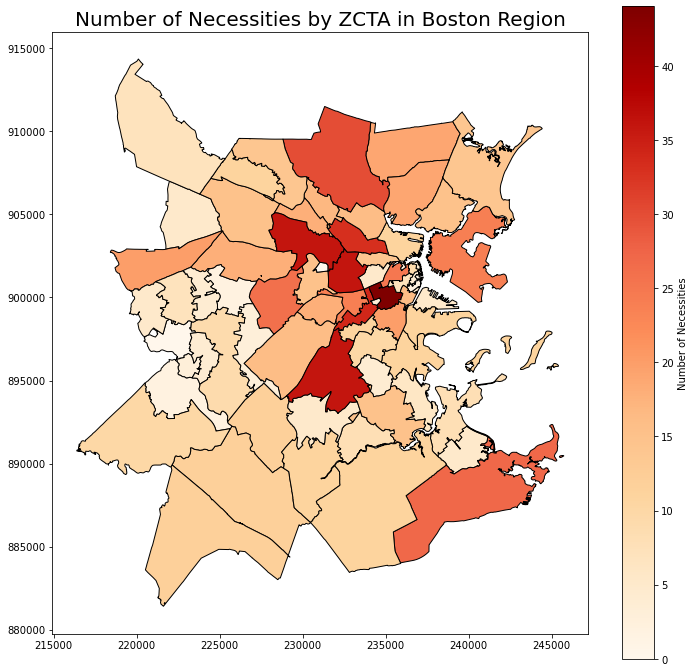

In [70]:
# Map the number of transit nodes in each ZCTA.
ax = zcta_necs.plot(column = 'necs_count',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'OrRd',
                      figsize = (12, 12),
                      legend_kwds={'label': "Number of Necessities"})
plt.title('Number of Necessities by ZCTA in Boston Region', fontsize = 20)
plt.show()

In [71]:
# Calculate node density in nodes/sqkm.
zcta_necs['necs_density'] = zcta_necs.necs_count/zcta_necs.area*(10**6)
zcta_necs.sort_values(by='necs_density', ascending=False).head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,grocery_count,healthcare_count,comm_health_count,hospitals_count,public_service_count,necs_count,necs_density
62,437,25,02113,2502113,B5,G6350,S,272995,0,+42.3651696,-071.0553627,N,"POLYGON ((236403.940 901958.860, 236443.429 90...",4.0,2.0,2.0,0.0,1.0,9.0,32.970055
68,495,25,02222,2502222,B5,G6350,S,77896,0,+42.3664695,-071.0624939,N,"POLYGON ((235839.790 902134.685, 235852.488 90...",2.0,0.0,0.0,0.0,0.0,2.0,25.683553
60,435,25,02116,2502116,B5,G6350,S,1712064,222385,+42.3499907,-071.0760802,N,"POLYGON ((234702.966 899809.334, 234675.900 89...",4.0,35.0,1.0,0.0,4.0,44.0,22.746898
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",3.0,4.0,5.0,1.0,3.0,16.0,21.088204
48,308,25,02199,2502199,B5,G6350,S,149678,0,+42.3474648,-071.0820577,N,"POLYGON ((234168.090 899801.270, 234292.861 89...",1.0,1.0,0.0,0.0,1.0,3.0,20.044386


In [72]:
zcta_necs.necs_density.describe()

count    69.000000
mean      4.712506
std       6.743782
min       0.000000
25%       1.002975
50%       1.862526
75%       5.201804
max      32.970055
Name: necs_density, dtype: float64

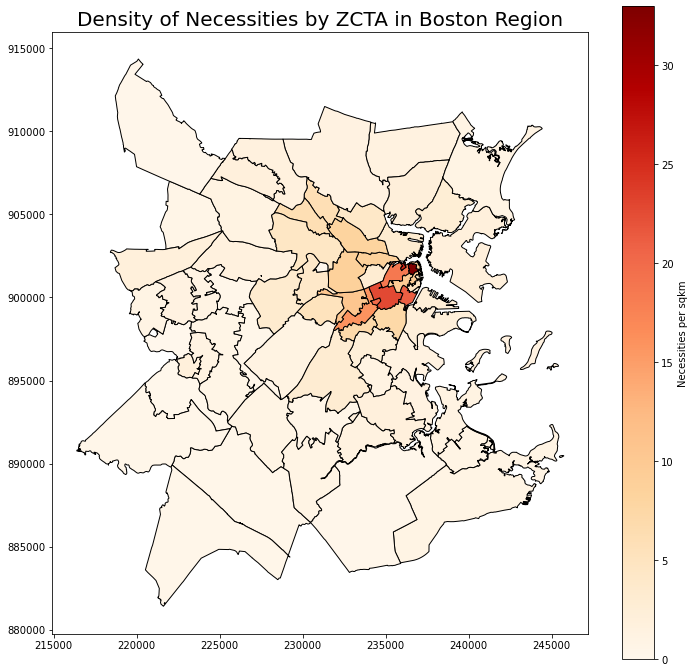

In [73]:
# Map the density of necessities in each ZCTA.
ax = zcta_necs.plot(column = 'necs_density',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'OrRd',
                      figsize = (12, 12),
                      legend_kwds={'label': "Necessities per sqkm"})
plt.title('Density of Necessities by ZCTA in Boston Region', fontsize = 20)
plt.show()

## Bike Facilities